<a href="https://colab.research.google.com/github/starlingomez/preworkmac/blob/master/NBA_PTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install nba_api

#Jerami Grant

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022300938   14    2    2    2    2   14    5     1     4    0    3    3   
1  0022300900   20    4    2    2    6   11    6     2     3    1    6    6   
2  0022300868    5    1    1    0    1    5    1     1     4    0    2    2   
3  0022300861   10    5    0    2    1   10    4     2     5    0    0    0   
4  0022300842   24    6    3    7    3   15    7     3     5    0    8    7   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0         -14           18       16        4       16          2  
1          -5           26       24        6       22          3  
2           3            6        6        1        5          1  
3          27           17       15        7       12          0  
4         -15           37       30       13       31          3  

XGBRegressor Pe

<ipython-input-9-aeb13b6a38ef>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])


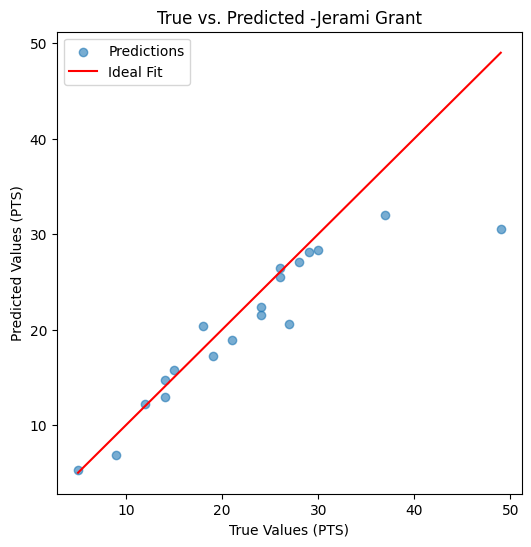


Using last 5-game averages for Jerami Grant:
   HOME  AST  REB  STL  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  2.4  2.0  0.2  0.4  9.2  3.8   1.6   4.2  0.4  4.0  3.6         5.0

Predicted AST for Jerami Grant: 11.55
The model predicts that Jerami Grant will go UNDER 15.5 in today's game.


In [9]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Jerami Grant.'s player ID
Jugador_id = players.find_players_by_full_name("Jerami Grant")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Tim Hardaway Jr.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'AST', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'PTS'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (PTS)')
plt.ylabel('Predicted Values (PTS)')
plt.title('True vs. Predicted -Jerami Grant')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['AST', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'AST': avg_stats['AST'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 15.5  # Example threshold
print(f"\nUsing last 5-game averages for Jerami Grant:")
print(today_game_df)
print(f"\nPredicted AST for Jerami Grant: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Jerami Grant will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Jerami Grant will go UNDER {threshold} in today's game.")


#Deandre Ayton

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301183    6    1    1    2    2   10    3     0     2    0    0    0   
1  0022301169   25    1    3   11    1   24   12     0     1    1    1    1   
2  0022301157   30    1    1   13    3   22   15     0     1    0    0    0   
3  0022301134   22    2    2   14    0   23   11     0     1    1    0    0   
4  0022301117   34    3    2   13    2   25   13     0     0    2    9    8   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0          -2            9        7        3        8          1  
1          -8           37       26       12       36          4  
2         -26           44       31       14       43          1  
3         -19           38       24       16       36          3  
4           8           50       37       16       47          4  

XGBRegressor Pe

<ipython-input-10-b2db5a85de8f>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])


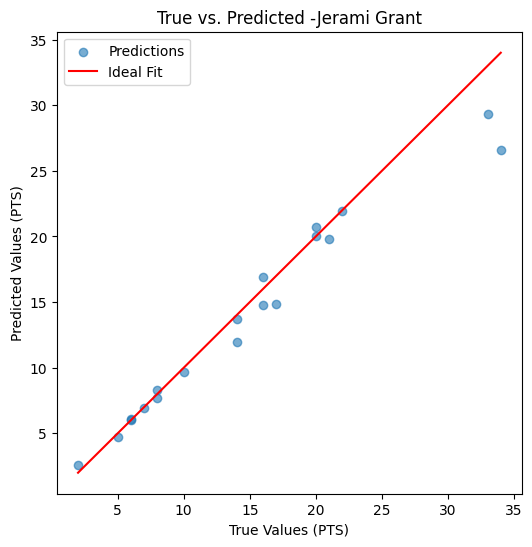


Using last 5-game averages for Deandre Ayton:
   HOME  AST   REB  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  2.2  11.6  1.4  1.6  14.6  8.6   0.0   0.4  0.8  3.8  2.8        17.4

Predicted AST for Deandre Ayton: 17.99
The model predicts that Deandre Ayton will go OVER 16.5 in today's game.


In [10]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Jerami Grant.'s player ID
Jugador_id = players.find_players_by_full_name("Deandre Ayton")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Deandre Ayton.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'AST', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'PTS'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (PTS)')
plt.ylabel('Predicted Values (PTS)')
plt.title('True vs. Predicted -Jerami Grant')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['AST', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'AST': avg_stats['AST'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 16.5  # Example threshold
print(f"\nUsing last 5-game averages for Deandre Ayton:")
print(today_game_df)
print(f"\nPredicted AST for Deandre Ayton: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Deandre Ayton will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Deandre Ayton will go UNDER {threshold} in today's game.")


#Deni Avdija

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301186    9    2    0    3    1   11    3     1     5    1    2    2   
1  0022301172   24    8    0   12    4   15    9     1     4    0    8    5   
2  0022301152   15    5    0    6    2   12    4     3     5    1    5    4   
3  0022301137   32    5    2   10    4   19   11     2     6    3   12    8   
4  0022301117   22    0    1   12    2   12    7     0     2    2    8    8   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0         -14           14       11        5       12          1  
1           5           44       32       20       36          0  
2           3           26       20       11       21          1  
3           1           47       37       15       42          5  
4           4           34       22       12       34          3  

XGBRegressor Pe

<ipython-input-12-9e3ddc8d45ae>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])


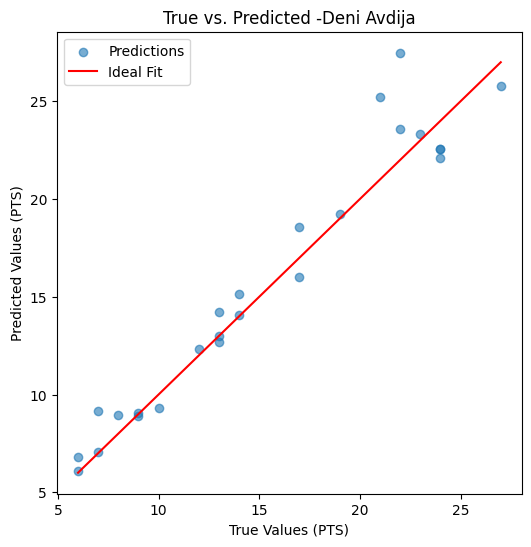


Using last 5-game averages for Deni Avdija:
   HOME  AST  REB  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  3.2  6.2  0.6  3.0  10.8  5.0   1.6   5.0  0.4  5.4  4.6         7.8

Predicted AST for Deni Avdija: 15.00
The model predicts that Deni Avdija will go UNDER 16.5 in today's game.


In [12]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find JDeni Avdija's player ID
Jugador_id = players.find_players_by_full_name("Deni Avdija")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Deni Avdija.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'AST', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'PTS'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (PTS)')
plt.ylabel('Predicted Values (PTS)')
plt.title('True vs. Predicted -Deni Avdija')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['AST', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'AST': avg_stats['AST'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 16.5  # Example threshold
print(f"\nUsing last 5-game averages for Deni Avdija:")
print(today_game_df)
print(f"\nPredicted AST for Deni Avdija: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Deni Avdija will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Deni Avdija will go UNDER {threshold} in today's game.")


#Toumani Camara

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301051   17    2    1    4    2    9    7     3     4    0    0    0   
1  0022301038   12    0    2    5    4    9    4     1     3    2    3    3   
2  0022301026   16    6    1    7    1   11    6     2     4    1    2    2   
3  0022301017   11    1    0    7    1   11    5     1     4    0    0    0   
4  0022301003    3    2    1    2    0    1    1     1     1    0    0    0   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0           0           23       19        6       21          1  
1          -7           17       12        5       17          4  
2           8           29       22       13       23          2  
3          -7           19       12        8       18          0  
4          -1            7        5        4        5          1  

XGBRegressor Pe

<ipython-input-13-ad1fa05294a9>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])


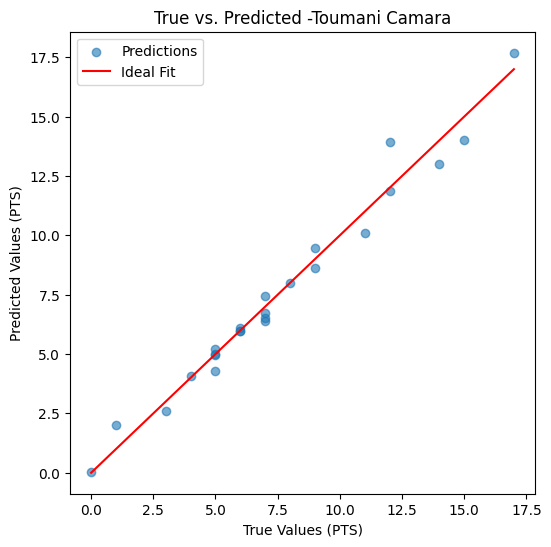


Using last 5-game averages for Toumani Camara:
   HOME  AST  REB  STL  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  1.8  7.6  1.2  1.8  7.2  4.8   1.6   3.2  0.8  1.6  1.4        22.2

Predicted AST for Toumani Camara: 9.42
The model predicts that Toumani Camara will go UNDER 16.5 in today's game.


In [13]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find JDeni Avdija's player ID
Jugador_id = players.find_players_by_full_name("Toumani Camara")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Toumani Camara.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'AST', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'PTS'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (PTS)')
plt.ylabel('Predicted Values (PTS)')
plt.title('True vs. Predicted -Toumani Camara')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['AST', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'AST': avg_stats['AST'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 16.5  # Example threshold
print(f"\nUsing last 5-game averages for Toumani Camara:")
print(today_game_df)
print(f"\nPredicted AST for Toumani Camara: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Toumani Camara will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Toumani Camara will go UNDER {threshold} in today's game.")


#Franz Wagner

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301191   25    3    3    5    0   21   10     1     5    0    4    4   
1  0022301171   24    3    1    6    1   18    9     1     4    1    5    5   
2  0022301136   16    3    1    4    0   10    5     1     4    0    5    5   
3  0022301115   22    1    1    7    1   16    8     0     4    0    8    6   
4  0022301109   24    5    0    2    4   14    8     3     6    1    6    5   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0          25           33       28        8       30          3  
1          -9           33       27        9       30          2  
2          15           23       19        7       20          1  
3          -6           30       23        8       29          1  
4          -2           31       29        7       26          1  


<ipython-input-17-58f940f3c0d3>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  12.5140
RMSE: 3.5375
R^2:  0.8259


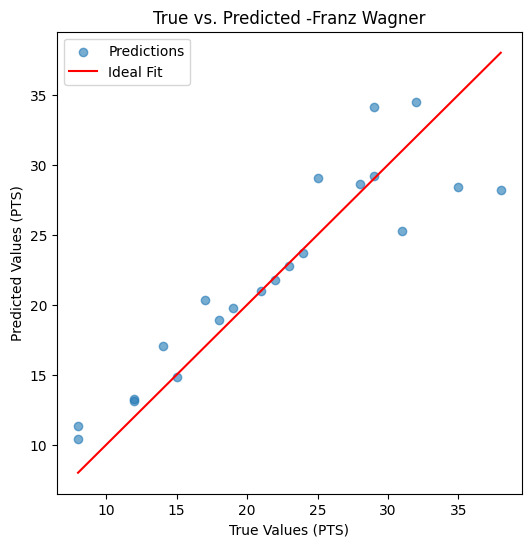


Using last 5-game averages for Franz Wagner:
   HOME  AST  REB  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     0  3.0  5.0  0.6  1.4  20.8  9.4   2.4   7.4  0.2  8.6  7.2         0.0

Predicted PTS for Franz Wagner: 27.25
The model predicts that Franz Wagner will go OVER 16.5 in today's game.


In [17]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find JDeni Avdija's player ID
Jugador_id = players.find_players_by_full_name("Franz Wagner")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Franz Wagner.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'AST', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'PTS'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (PTS)')
plt.ylabel('Predicted Values (PTS)')
plt.title('True vs. Predicted -Franz Wagner')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['AST', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 0,  # Change to 1 if he's at home today
    'AST': avg_stats['AST'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 16.5  # Example threshold
print(f"\nUsing last 5-game averages for Franz Wagner:")
print(today_game_df)
print(f"\nPredicted PTS for Franz Wagner: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Franz Wagner will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Franz Wagner will go UNDER {threshold} in today's game.")


#Goga Bitadze

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301191    0    1    0    3    0    1    0     0     1    0    0    0   
1  0022301171    5    0    2    2    2    4    2     0     0    1    1    1   
2  0022301162    2    0    0    3    0    1    0     0     0    0    4    2   
3  0022301150    0    0    0    0    0    0    0     0     0    0    0    0   
4  0022301136    0    0    0    0    0    0    0     0     0    0    0    0   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0          -2            4        1        4        3          0  
1         -17            7        5        2        7          3  
2           4            5        2        3        5          0  
3           0            0        0        0        0          0  
4           1            0        0        0        0          0  


<ipython-input-15-21b92331fab1>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  0.3934
RMSE: 0.6272
R^2:  0.9847


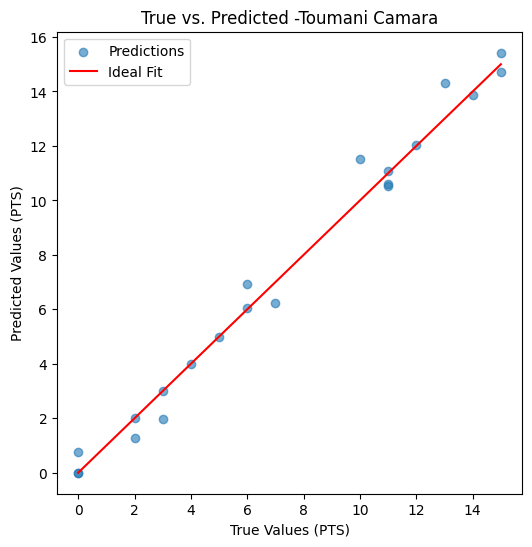


Using last 5-game averages for Goga Bitadze:
   HOME  AST  REB  STL  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     0  2.0  8.2  0.4  1.0  4.4  3.0   0.0   0.0  1.4  2.2  1.0        -1.4

Predicted PTS for Goga Bitadze: 9.04
The model predicts that Goga Bitadze will go OVER 7.5 in today's game.


In [15]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find JDeni Avdija's player ID
Jugador_id = players.find_players_by_full_name("Goga Bitadze")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Goga Bitadze.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'AST', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'PTS'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (PTS)')
plt.ylabel('Predicted Values (PTS)')
plt.title('True vs. Predicted -Toumani Camara')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['AST', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 0,  # Change to 1 if he's at home today
    'AST': avg_stats['AST'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 7.5  # Example threshold
print(f"\nUsing last 5-game averages for Goga Bitadze:")
print(today_game_df)
print(f"\nPredicted PTS for Goga Bitadze: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Goga Bitadze will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Goga Bitadze will go UNDER {threshold} in today's game.")


#Jayson Tatum

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301167   18    7    2    4    2   13    5     1     7    1    9    7   
1  0022301148   22    6    0    5    2   19    9     4     9    1    0    0   
2  0022301118   17    5    0    6    3   15    5     1     6    0    8    6   
3  0022301105   24    3    1    7    0   15    7     2     5    0    8    8   
4  0022301087   25    4    2   10    4   19    9     4    10    1    3    3   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0         -30           29       25       11       22          3  
1         -11           33       28       11       27          1  
2          14           28       22       11       23          0  
3          14           34       27       10       31          1  
4          14           39       29       14       35          3  


<ipython-input-18-0bc8e0bef876>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  7.4774
RMSE: 2.7345
R^2:  0.8172


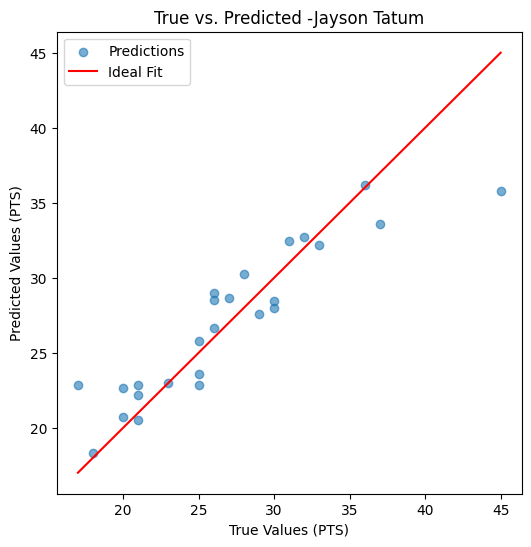


Using last 5-game averages for Jayson Tatum:
   HOME  AST  REB  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     0  8.0  6.2  0.8  3.0  18.6  8.0   3.0   8.4  0.6  5.6  4.8         6.4

Predicted PTS for Jayson Tatum: 22.92
The model predicts that Jayson Tatum will go UNDER 25.5 in today's game.


In [18]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Jayson Tatum's player ID
Jugador_id = players.find_players_by_full_name("Jayson Tatum")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Jayson Tatum.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'AST', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'PTS'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (PTS)')
plt.ylabel('Predicted Values (PTS)')
plt.title('True vs. Predicted -Jayson Tatum')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['AST', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 0,  # Change to 1 if he's at home today
    'AST': avg_stats['AST'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 25.5  # Example threshold
print(f"\nUsing last 5-game averages for Jayson Tatum:")
print(today_game_df)
print(f"\nPredicted PTS for Jayson Tatum: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Jayson Tatum will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Jayson Tatum will go UNDER {threshold} in today's game.")


#Derrick White

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301167    2    2    1    2    1    5    1     0     3    1    0    0   
1  0022301148    9    3    2    4    1   10    3     3     9    0    0    0   
2  0022301134   15    9    1    1    2   13    5     3    10    0    2    2   
3  0022301105    8    6    1    1    0    5    2     2     4    1    2    2   
4  0022301087   19    5    0    9    2   15    7     4    10    1    1    1   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0         -29            6        4        4        4          2  
1         -11           16       12        7       13          2  
2           2           25       24       10       16          1  
3          13           15       14        7        9          2  
4          13           33       24       14       28          1  


<ipython-input-20-af79b5d04660>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  3.8036
RMSE: 1.9503
R^2:  0.9267


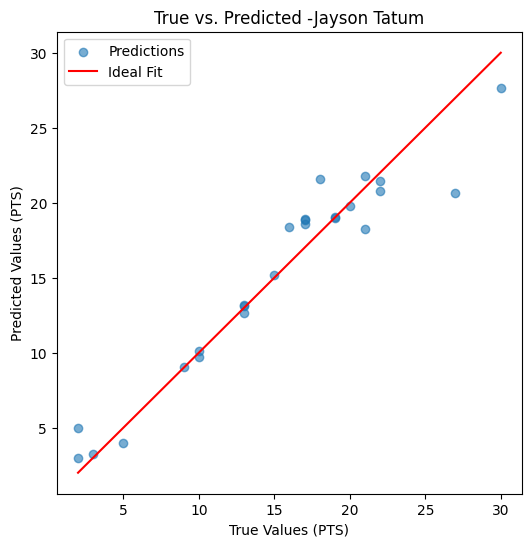


Using last 5-game averages for Derrick White:
   HOME  AST  REB  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     0  4.6  3.0  0.8  0.6  12.8  6.4   4.4   9.4  0.6  3.2  2.4         3.8

Predicted PTS for Derrick White: 17.19
The model predicts that Derrick White will go OVER 15.5 in today's game.


In [20]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Jayson Tatum's player ID
Jugador_id = players.find_players_by_full_name("Derrick White")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Derrick White.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'AST', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'PTS'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (PTS)')
plt.ylabel('Predicted Values (PTS)')
plt.title('True vs. Predicted -Jayson Tatum')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['AST', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 0,  # Change to 1 if he's at home today
    'AST': avg_stats['AST'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 15.5  # Example threshold
print(f"\nUsing last 5-game averages for Derrick White:")
print(today_game_df)
print(f"\nPredicted PTS for Derrick White: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Derrick White will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Derrick White will go UNDER {threshold} in today's game.")


#Keegan Murray

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301200   12    1    1    5    1   12    4     2     7    1    2    2   
1  0022301185   23    0    3    7    0   19    9     5    12    0    0    0   
2  0022301170   19    1    2    5    0   14    6     5    10    0    2    2   
3  0022301153   15    2    0   10    0   16    5     3    10    0    2    2   
4  0022301141   19    4    0    6    0   18    7     3    10    4    2    2   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0          26           18       13        6       17          2  
1          -2           30       23        7       30          3  
2          -9           25       20        6       24          2  
3          -8           27       17       12       25          0  
4          20           29       23       10       25          4  


<ipython-input-21-ca5c0a4ec4d5>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  1.4743
RMSE: 1.2142
R^2:  0.9701


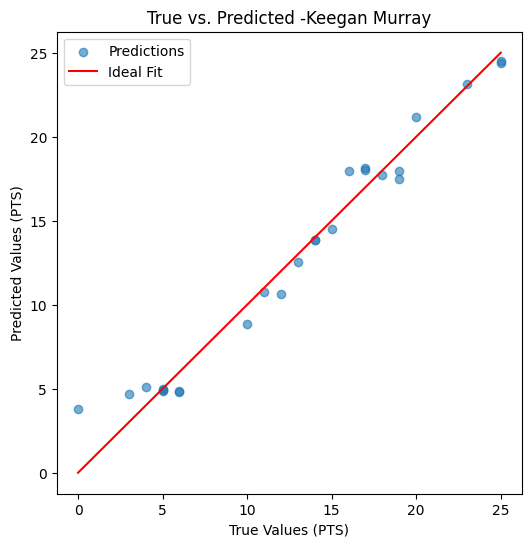


Using last 5-game averages for Keegan Murray:
   HOME  AST  REB  STL  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     0  0.8  5.8  0.8  1.0  9.8  5.2   1.6   4.2  0.6  1.2  0.8        -8.0

Predicted PTS for Keegan Murray: 13.26
The model predicts that Keegan Murray will go OVER 11.5 in today's game.


In [21]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Keegan Murray's player ID
Jugador_id = players.find_players_by_full_name("Keegan Murray")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Keegan Murray.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'AST', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'PTS'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (PTS)')
plt.ylabel('Predicted Values (PTS)')
plt.title('True vs. Predicted -Keegan Murray')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['AST', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 0,  # Change to 1 if he's at home today
    'AST': avg_stats['AST'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 11.5  # Example threshold
print(f"\nUsing last 5-game averages for Keegan Murray:")
print(today_game_df)
print(f"\nPredicted PTS for Keegan Murray: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Keegan Murray will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Keegan Murraywill go UNDER {threshold} in today's game.")


#Kyrie Irving

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301161   25    4    2    3    1   15   10     5     8    0    0    0   
1  0022301144   18    9    2    8    2   15    6     2     8    3    5    4   
2  0022301131   48    2    1    7    2   25   15     3     8    0   17   15   
3  0022301097   26    7    2    8    5   19    9     2     7    1    6    6   
4  0022301124   26    1    0    5    4   21   10     3     7    1    3    3   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0          11           32       29        7       28          2  
1          24           35       27       17       26          5  
2          21           57       50        9       55          1  
3           1           41       33       15       34          3  
4           7           32       27        6       31          1  

XGBRegressor Pe

<ipython-input-22-737be0c4592a>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])


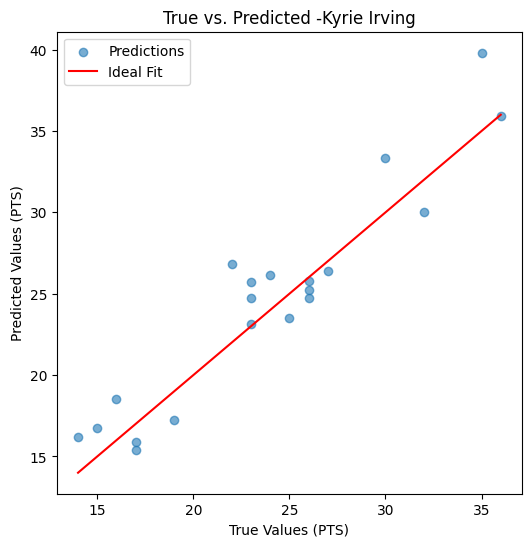


Using last 5-game averages for Kyrie Irving:
   HOME  AST  REB  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     0  4.6  6.6  0.6  2.4  19.4  9.0   2.0   7.2  0.4  5.0  4.4        -1.2

Predicted PTS for Kyrie Irving: 22.40
The model predicts that Kyrie Irving will go UNDER 25.5 in today's game.


In [22]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Kyrie Irving's player ID
Jugador_id = players.find_players_by_full_name("Kyrie Irving")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Kyrie Irvingy.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'AST', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'PTS'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (PTS)')
plt.ylabel('Predicted Values (PTS)')
plt.title('True vs. Predicted -Kyrie Irving')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['AST', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 0,  # Change to 1 if he's at home today
    'AST': avg_stats['AST'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 25.5  # Example threshold
print(f"\nUsing last 5-game averages for Kyrie Irving:")
print(today_game_df)
print(f"\nPredicted PTS for Kyrie Irving: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Kyrie Irving will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Kyrie Irving will go UNDER {threshold} in today's game.")


#Anthony Edwards

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301194   13    4    1    6    5    7    3     0     2    1    8    7   
1  0022301178   14    4    2    4    3   12    4     0     5    0    6    6   
2  0022301164   25    4    0    2    1   18    9     2     6    0    7    5   
3  0022301152   51    7    0    6    2   29   17     6    13    0   11   11   
4  0022301143   26    8    1    1    1   20    9     3     8    0    5    5   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0         -21           23       17       10       19          2  
1           0           22       18        8       18          2  
2         -16           31       29        6       27          0  
3           6           64       58       13       57          0  
4           2           35       34        9       27          1  


<ipython-input-23-aa879afd6541>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  5.7149
RMSE: 2.3906
R^2:  0.9257


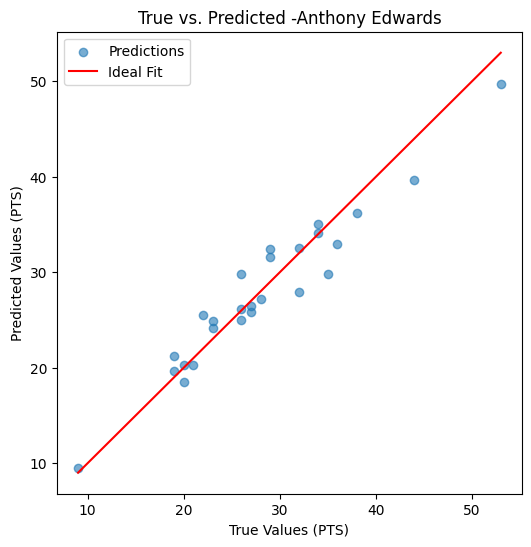


Using last 5-game averages for Anthony Edwards:
   HOME  AST  REB  STL  TOV   FGA  FGM  FG3M  FG3A  BLK   FTA  FTM  PLUS_MINUS
0     1  5.4  6.6  1.4  4.2  21.4  9.8   4.0  10.4  2.0  10.2  8.8        12.0

Predicted PTS for Anthony Edwards: 28.54
The model predicts that Anthony Edwards will go OVER 28.5 in today's game.


In [23]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Anthony Edwards's player ID
Jugador_id = players.find_players_by_full_name("Anthony Edwards")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Anthony Edwards.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'AST', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'PTS'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (PTS)')
plt.ylabel('Predicted Values (PTS)')
plt.title('True vs. Predicted -Anthony Edwards')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['AST', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'AST': avg_stats['AST'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 28.5  # Example threshold
print(f"\nUsing last 5-game averages for Anthony Edwards:")
print(today_game_df)
print(f"\nPredicted PTS for Anthony Edwards: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Anthony Edwards will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Anthony Edwards will go UNDER {threshold} in today's game.")


#Jaden McDaniels

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301194    6    1    0    0    3    7    2     1     4    0    2    1   
1  0022301178   11    1    0    3    0    7    4     3     4    1    0    0   
2  0022301164    9    3    1    2    0    8    4     1     4    0    0    0   
3  0022301152    9    2    1    5    0    6    3     1     4    1    2    2   
4  0022301143   11    2    0    3    0    9    5     0     2    0    1    1   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0         -11            7        7        1        6          0  
1           8           15       12        4       14          1  
2         -17           14       12        5       11          1  
3         -10           16       11        7       14          2  
4           4           16       13        5       14          0  


<ipython-input-24-c1b467942598>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  2.2626
RMSE: 1.5042
R^2:  0.9261


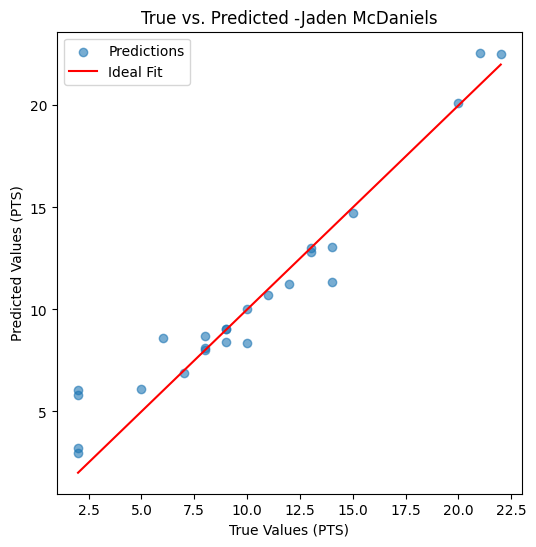


Using last 5-game averages for Jaden McDaniels:
   HOME  AST  REB  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  2.4  7.4  1.4  1.6  10.8  5.2   1.8   4.0  1.0  3.0  2.8         6.6

Predicted PTS for Jaden McDaniels: 12.82
The model predicts that Jaden McDaniels will go OVER 12.5 in today's game.


In [24]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Jaden McDaniels's player ID
Jugador_id = players.find_players_by_full_name("Jaden McDaniels")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Jaden McDaniels.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'AST', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'PTS'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (PTS)')
plt.ylabel('Predicted Values (PTS)')
plt.title('True vs. Predicted -Jaden McDaniels')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['AST', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'AST': avg_stats['AST'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 12.5  # Example threshold
print(f"\nUsing last 5-game averages for Jaden McDaniels:")
print(today_game_df)
print(f"\nPredicted PTS for Jaden McDaniels: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Jaden McDaniels will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Jaden McDaniels will go UNDER {threshold} in today's game.")


#Dillon Brooks

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301183    9    0    0    5    1   10    4     1     5    1    0    0   
1  0022301168    8    1    2    4    1   14    4     0     5    0    0    0   
2  0022301150   15    3    0    5    1   10    5     3     4    0    2    2   
3  0022301131   29    2    3    2    1   14    9     5     6    0    7    6   
4  0022301120   18    3    1    5    0   13    5     3     7    0    6    5   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0          -1           14        9        5       14          1  
1          -6           13        9        5       12          2  
2          20           23       18        8       20          0  
3         -16           33       31        4       31          3  
4         -15           26       21        8       23          1  


<ipython-input-25-feca4f6dfd9a>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  2.1689
RMSE: 1.4727
R^2:  0.9195


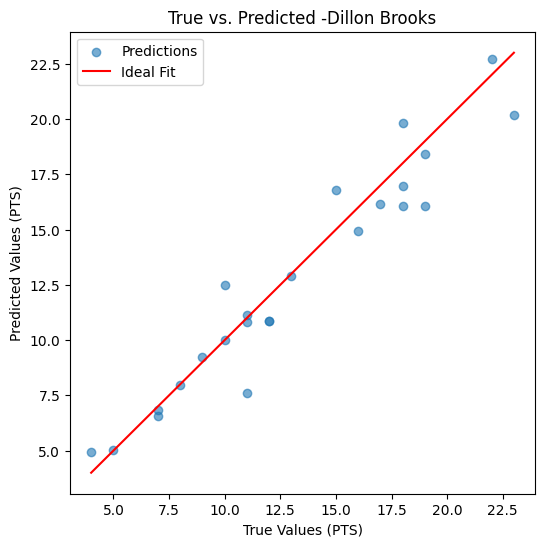


Using last 5-game averages for Dillon Brooks:
   HOME  AST  REB  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  1.0  4.4  0.4  1.6  13.2  5.6   2.4   6.0  0.0  1.8  1.6        -4.6

Predicted PTS for Dillon Brooks: 13.19
The model predicts that Dillon Brooks will go OVER 12.5 in today's game.


In [25]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Jaden McDaniels's player ID
Jugador_id = players.find_players_by_full_name("Dillon Brooks")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Dillon Brooks.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'AST', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'PTS'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (PTS)')
plt.ylabel('Predicted Values (PTS)')
plt.title('True vs. Predicted -Dillon Brooks')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['AST', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'AST': avg_stats['AST'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 12.5  # Example threshold
print(f"\nUsing last 5-game averages for Dillon Brooks:")
print(today_game_df)
print(f"\nPredicted PTS for Dillon Brooks: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Dillon Brooks will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Dillon Brooks will go UNDER {threshold} in today's game.")


#Naz Reid

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301194   10    1    1    4    4    8    4     2     5    0    0    0   
1  0022301178   19    2    0    3    2   10    5     2     5    1    8    7   
2  0022301164   13    2    2    6    0   19    6     0     4    1    5    1   
3  0022301152    3    0    1    2    0    5    1     1     2    1    0    0   
4  0022301143   31    1    2   11    1   16   12     6     8    1    3    1   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0         -17           15       11        5       14          1  
1          -3           24       21        5       22          1  
2           3           21       15        8       19          3  
3         -15            5        3        2        5          2  
4          11           43       32       12       42          3  


<ipython-input-26-c1f6b36bb02e>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  2.1143
RMSE: 1.4541
R^2:  0.9380


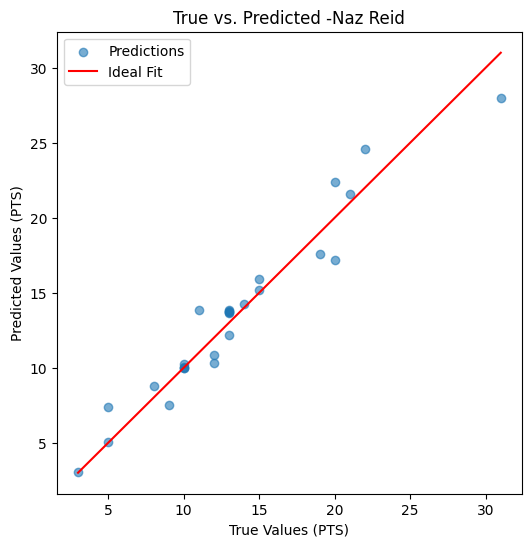


Using last 5-game averages for Naz Reid:
   HOME  AST  REB  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  3.0  5.0  0.4  0.8  12.4  6.6   3.6   7.0  0.8  0.6  0.6         9.8

Predicted PTS for Naz Reid: 16.06
The model predicts that Naz Reid will go UNDER 17.5 in today's game.


In [26]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Naz Reid's player ID
Jugador_id = players.find_players_by_full_name("Naz Reid")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Naz Reid.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'AST', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'PTS'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (PTS)')
plt.ylabel('Predicted Values (PTS)')
plt.title('True vs. Predicted -Naz Reid')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['AST', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'AST': avg_stats['AST'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 17.5  # Example threshold
print(f"\nUsing last 5-game averages for Naz Reid:")
print(today_game_df)
print(f"\nPredicted PTS for Naz Reid: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Naz Reid will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Naz Reid will go UNDER {threshold} in today's game.")


#Amen Thompson

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301199   18   10    3   11    3    9    8     0     0    3    3    2   
1  0022301183   17    6    0   15    2   12    6     0     1    0    6    5   
2  0022301168   15    4    2   10    1   12    6     0     1    0    4    3   
3  0022301150   13    4    2    8    4    7    6     0     0    1    2    1   
4  0022301131    5    3    0    3    0    1    1     0     0    0    3    3   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0          12           39       28       21       29          6  
1          15           38       23       21       32          0  
2          -1           29       19       14       25          2  
3           1           25       17       12       21          3  
4          17           11        8        6        8          0  


<ipython-input-27-5963169f784c>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  1.7463
RMSE: 1.3215
R^2:  0.9431


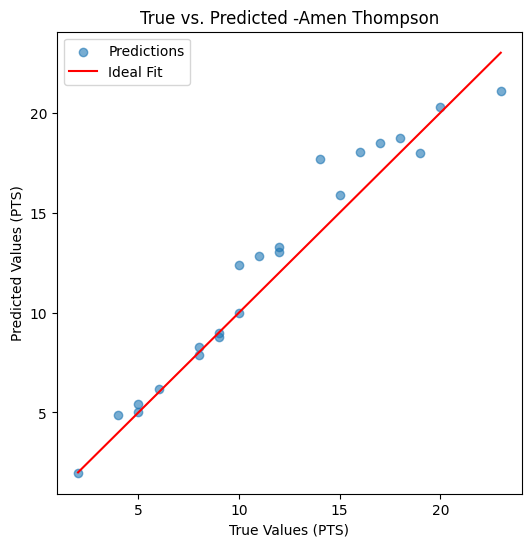


Using last 5-game averages for Naz Reid:
   HOME  AST  REB  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  6.6  7.8  2.2  2.6  11.8  5.0   0.0   0.8  1.8  5.2  4.4        -0.8

Predicted PTS for Naz Reid: 16.03
The model predicts that Amen Thompson will go UNDER 17.5 in today's game.


In [27]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Naz Reid's player ID
Jugador_id = players.find_players_by_full_name("Amen Thompson")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Amen Thompson.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'AST', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'PTS'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (PTS)')
plt.ylabel('Predicted Values (PTS)')
plt.title('True vs. Predicted -Amen Thompson')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['AST', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'AST': avg_stats['AST'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 17.5  # Example threshold
print(f"\nUsing last 5-game averages for Naz Reid:")
print(today_game_df)
print(f"\nPredicted PTS for Naz Reid: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Amen Thompson will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Amen Thompson will go UNDER {threshold} in today's game.")


#Obi Toppin

Retrieving data for season: 2023-24
Retrieving data for season: 2024-25

Data preview (trimmed DataFrame):
      Game_ID  PTS  AST  STL  REB  TOV  FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  \
0  0022301199   18   10    3   11    3    9    8     0     0    3    3    2   
1  0022301183   17    6    0   15    2   12    6     0     1    0    6    5   
2  0022301168   15    4    2   10    1   12    6     0     1    0    4    3   
3  0022301150   13    4    2    8    4    7    6     0     0    1    2    1   
4  0022301131    5    3    0    3    0    1    1     0     0    0    3    3   

   PLUS_MINUS  PTS+REB+AST  PTS+AST  REB+AST  PTS+REB  BLKS+STLS  
0          12           39       28       21       29          6  
1          15           38       23       21       32          0  
2          -1           29       19       14       25          2  
3           1           25       17       12       21          3  
4          17           11        8        6        8          0  


<ipython-input-27-5963169f784c>:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])



XGBRegressor Performance:
MSE:  1.7463
RMSE: 1.3215
R^2:  0.9431


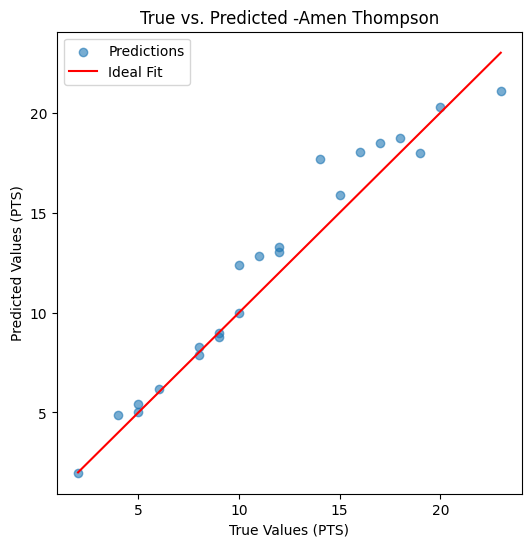


Using last 5-game averages for Naz Reid:
   HOME  AST  REB  STL  TOV   FGA  FGM  FG3M  FG3A  BLK  FTA  FTM  PLUS_MINUS
0     1  6.6  7.8  2.2  2.6  11.8  5.0   0.0   0.8  1.8  5.2  4.4        -0.8

Predicted PTS for Naz Reid: 16.03
The model predicts that Amen Thompson will go UNDER 17.5 in today's game.


In [ ]:
#!pip install nba_api xgboost

# =============== 1. Imports ===============
from nba_api.stats.static import players
import pandas as pd
from nba_api.stats.endpoints import PlayerGameLog
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# =============== 2. Data Retrieval ===============
# Find Naz Reid's player ID
Jugador_id = players.find_players_by_full_name("Amen Thompson")[0]['id']

# Retrieve game logs for the 2023-24 and 2024-25 seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=Jugador_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

# =============== 3. Feature Engineering ===============
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST']     = df['PTS'] + df['AST']
df['REB+AST']     = df['REB'] + df['AST']
df['PTS+REB']     = df['PTS'] + df['REB']
df['BLKS+STLS']   = df['BLK']  + df['STL']

# Save to CSV (contains all columns, including GAME_DATE, MATCHUP, etc.)
output_filename = 'Amen Thompson.csv'
df.to_csv(output_filename, index=False)

# (Optional) Drop columns from df if you want a trimmed view in the current DataFrame
df_trimmed = df.drop(columns=['GAME_DATE', 'MATCHUP'])

print("\nData preview (trimmed DataFrame):")
print(df_trimmed.head())

# =============== 4. Model Training & Evaluation ===============
# Reload the full dataset from CSV (which has GAME_DATE and MATCHUP for further feature engineering)
data = pd.read_csv(output_filename)

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
data['HOME'] = data['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# (Optional) Create an 'OPPONENT' feature
data['OPPONENT'] = data['MATCHUP'].apply(lambda x: x.split()[-1])

# Define features and target
features = [
    'HOME', 'AST', 'REB', 'STL', 'TOV',
    'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA',
    'FTM', 'PLUS_MINUS'
]
target = 'PTS'

# Split features (X) and target (y)
X = data[features]
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train an XGBoost Regressor
xgb_reg = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1
)
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
predictions = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\nXGBRegressor Performance:")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R^2:  {r2:.4f}")

# Optional: Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predictions, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Ideal Fit')
plt.xlabel('True Values (PTS)')
plt.ylabel('Predicted Values (PTS)')
plt.title('True vs. Predicted -Amen Thompson')
plt.legend()
plt.show()

# =============== 5. Example Prediction (Today’s Game) ===============
# Gather the last 5 games from 'Fred_VanVleet.csv' and compute average stats
data_sorted = data.sort_values(by='GAME_DATE')  # Ensures games are in chronological order
last_5_games = data_sorted.tail(5)
avg_stats = last_5_games[['AST', 'REB', 'STL', 'TOV', 'FGA', 'FGM',
                          'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']].mean()

# Create the input dictionary based on the 5-game averages
# NOTE: Manually set 'HOME' to 1 (home) or 0 (away) for today's matchup.
today_game = {
    'HOME': 1,  # Change to 1 if he's at home today
    'AST': avg_stats['AST'],
    'REB': avg_stats['REB'],
    'STL': avg_stats['STL'],
    'TOV': avg_stats['TOV'],
    'FGA': avg_stats['FGA'],
    'FGM': avg_stats['FGM'],
    'FG3M': avg_stats['FG3M'],
    'FG3A': avg_stats['FG3A'],
    'BLK': avg_stats['BLK'],
    'FTA': avg_stats['FTA'],
    'FTM': avg_stats['FTM'],
    'PLUS_MINUS': avg_stats['PLUS_MINUS']
}

today_game_df = pd.DataFrame([today_game])
today_game_prediction = xgb_reg.predict(today_game_df)
predicted_value = today_game_prediction[0]

threshold = 17.5  # Example threshold
print(f"\nUsing last 5-game averages for Naz Reid:")
print(today_game_df)
print(f"\nPredicted PTS for Naz Reid: {predicted_value:.2f}")

if predicted_value > threshold:
    print(f"The model predicts that Amen Thompson will go OVER {threshold} in today's game.")
else:
    print(f"The model predicts that Amen Thompson will go UNDER {threshold} in today's game.")
